In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
from deltasigma import *
from IPython.core.display import Image

In [3]:
# skip this, this is just to display nice tables.
from itertools import zip_longest
class Table(list):
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            for col in row:
                try:
                    float(col)
                    html.append("<td>%.6f</td>" % col)
                except(ValueError):
                    html.append("<td><b>%s</b></td>" % col)
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

# Modulator realization and dynamic range scaling - # demo3

In this ipython notebook, the following is demonstrated:

 * A 5th order delta sigma modulator is synthesized, with optimized zeros and an OSR equal to 42.

 * We then convert the synthesized NTF into `a`, `g`, `b`, `c` coefficients for the `CRFB` modulator structure.
 
 * The maxima for each state are evaluated.
 
 * The `ABCD` matrix is scaled so that the state maxima are less than the specified limit.

 * The state maxima are re-evaluated and limit compliance is checked.

**NOTE:** This is an ipython port of `dsdemo3.m`, from the **[MATLAB Delta Sigma Toolbox](http://www.mathworks.com/matlabcentral/fileexchange/19-delta-sigma-toolbox)**, written by Richard Schreier.

## Delta sigma modulator synthesis

In [4]:
order = 5
R = 42
opt = 1
H = synthesizeNTF(order, R, opt)

Let's inspect the NTF, printing out the transfer function and plotting poles and zeros with respect to the unit circle.

In [5]:
print(pretty_lti(H))

        (z^2 - 1.995z + 1) (z^2 - 1.998z + 1) (z - 1)         
--------------------------------------------------------------
 (z^2 - 1.614z + 0.6657) (z^2 - 1.797z + 0.8552) (z - 0.7783) 


/home/urosminoski/anaconda3/envs/deltasigma/lib/python3.7/site-packages/deltasigma-0.2.2-py3.7.egg/deltasigma/_plotPZ.py:85: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  hold_status = plt.ishold()
/home/urosminoski/anaconda3/envs/deltasigma/lib/python3.7/site-packages/deltasigma-0.2.2-py3.7.egg/deltasigma/_plotPZ.py:90: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True)
/home/urosminoski/anaconda3/envs/deltasigma/lib/python3.7/site-packages/matplotlib/__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/urosminoski/anaconda3/envs/deltasigma/lib/python3.7/s

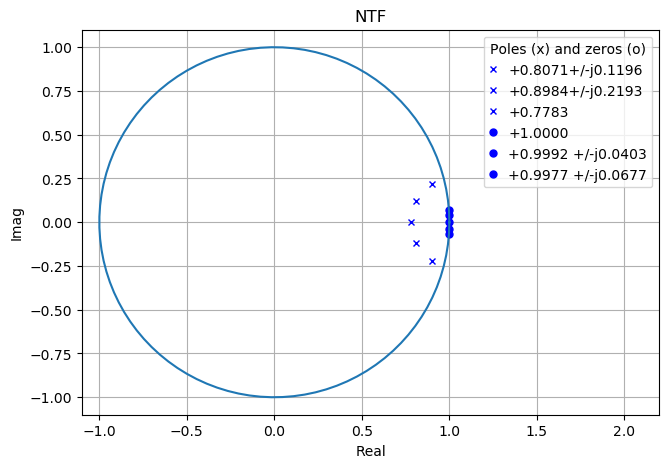

In [6]:
figure(figsize=(10, 5))
plotPZ(H, showlist=True)
title('NTF');

## Evaluation of the coefficients for a CRFB topology
The CRFB topology is depicted in the following diagram.

In [7]:
Image(url='http://python-deltasigma.readthedocs.org/en/latest/_images/CRFB.png', retina=True)

Since the modulator order is 5, we're interested in the topology for odd order modulators.

## Unscaled modulator

### Calculate the coefficients

In [8]:
a, g, b, c = realizeNTF(H)

/home/urosminoski/anaconda3/envs/deltasigma/lib/python3.7/site-packages/deltasigma-0.2.2-py3.7.egg/deltasigma/_realizeNTF.py:149: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a = -np.real(np.linalg.lstsq(T.T, L1.T)[0]).T


### Feed-in selection
We'll use a single feed-in for the input, to have a maximally flat STF.

This means setting $\ b_n = 0, \ \forall n > 1$.

In [9]:
b = np.concatenate((b[0].reshape((1, )), np.zeros((b.shape[0] - 1, ))), axis=0)

In [10]:
t = Table()
ilabels = ['#1', '#2', '#3', '#4', '#5', '#6']
t.append(['Coefficients', 'DAC feedback', 'Resonator feedback', 
          'Feed-in', 'Interstage'])
t.append(['', 'a(n)', 'g(n)', ' b(n)', ' c(n)'])
[t.append(x) for x in zip_longest(ilabels, a.tolist(), g.tolist(), b.tolist(), c.tolist(), fillvalue="")]
t

Coefficients,DAC feedback,Resonator feedback,Feed-in,Interstage
,a(n),g(n),b(n),c(n)
#1,0.000667,0.001622,0.000667,1.000000
#2,0.008583,0.004593,0.000000,1.000000
#3,0.055201,,0.000000,1.000000
#4,0.247607,,0.000000,1.000000
#5,0.556935,,0.000000,1.000000
#6,,,0.000000,


### Calculate the state maxima

In [11]:
ABCD = stuffABCD(a, g, b, c);
u = np.linspace(0, 0.6, 30);
N = int(1e4); 
T = np.ones((1, N))
maxima = np.zeros((order, len(u)))
for i in range(len(u)):
    ui = u[i]
    v, xn, xmax, _ = simulateDSM(ui*T, ABCD);
    maxima[:, i] = np.squeeze(xmax)
    if any(xmax > 1e2):
        umax = ui;
        u = u[:i];
        maxima = maxima[:, :i]
        break;
# save the maxima
prescale_maxima = np.copy(maxima)
print('The state maxima have been evaluated through simulation.')

The state maxima have been evaluated through simulation.


/home/urosminoski/anaconda3/envs/deltasigma/lib/python3.7/site-packages/deltasigma-0.2.2-py3.7.egg/deltasigma/_stuffABCD.py:75: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ABCD[subdiag] = c[0, even:order:2]
/home/urosminoski/anaconda3/envs/deltasigma/lib/python3.7/site-packages/deltasigma-0.2.2-py3.7.egg/deltasigma/_stuffABCD.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ABCD[supdiag] = -g.reshape((-1,))


### Plot of the state maxima

/home/urosminoski/anaconda3/envs/deltasigma/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.


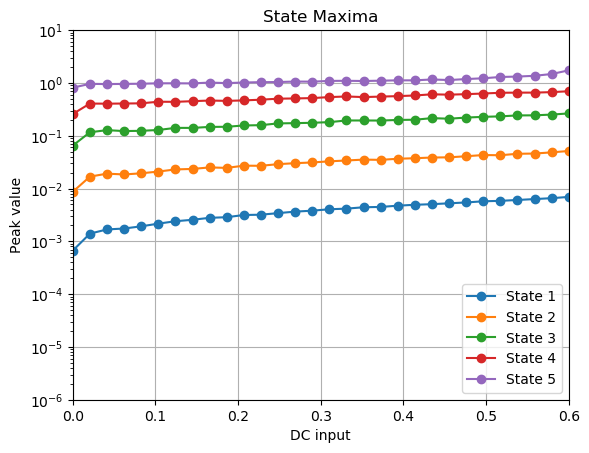

In [12]:
for i in range(order):
    semilogy(u, maxima[i, :], 'o-', label=('State %d' % (i+1)))
    if not i:
        hold(True)
grid(True)
title('State Maxima'); ylabel('Peak value'); xlabel('DC input')
xlim([0, 0.6]); ylim([1e-6, 10]);
legend(loc=4);

## Scaled modulator
### Calculate the scaled coefficients

In [13]:
ABCDs, umax, _ = scaleABCD(ABCD, N_sim=int(1e5))
as_, gs, bs, cs = mapABCD(ABCDs)
print('\nScaled modulator, umax = %.2f\n' % umax)


Scaled modulator, umax = 0.58



/home/urosminoski/anaconda3/envs/deltasigma/lib/python3.7/site-packages/deltasigma-0.2.2-py3.7.egg/deltasigma/_mapABCD.py:65: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  g = -ABCD[supdiag]


In [14]:
t = Table()
ilabels = ['#1', '#2', '#3', '#4', '#5', '#6']
t.append(['Coefficients', 'DAC feedback', 'Resonator feedback', 
          'Feed-in', 'Interstage'])
t.append(['', 'a(n)', 'g(n)', ' b(n)', ' c(n)'])
[t.append(x) for x in zip_longest(ilabels, as_.tolist(), gs.tolist(), bs.tolist(), cs.tolist(), fillvalue="")]
t

Coefficients,DAC feedback,Resonator feedback,Feed-in,Interstage
,a(n),g(n),b(n),c(n)
#1,0.100298,0.008508,0.100298,0.135347
#2,0.174656,0.010817,0.000000,0.190649
#3,0.214165,,0.000000,0.380271
#4,0.365304,,0.000000,0.424567
#5,0.348852,,0.000000,1.596478
#6,,,0.000000,


### Calculate the state maxima

In [15]:
u = np.linspace(0, umax, 30)
N = int(1e4)
T = np.ones((N,))
maxima = np.zeros((order, len(u)))
for i in range(len(u)):
    ui = u[i]
    v, xn, xmax, _ = simulateDSM(ui*T, ABCDs)
    maxima[:, i] = xmax.squeeze()
    if any(xmax > 1e2):
        umax = ui;
        u = u[:i]
        maxima = maxima[:, :i]
        break
print('The state maxima have been re-evaluated through simulation.')
print("The maximum input was found to be %.6f" % umax)

The state maxima have been re-evaluated through simulation.
The maximum input was found to be 0.583333


### Plot of the state maxima after scaling

/home/urosminoski/anaconda3/envs/deltasigma/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.


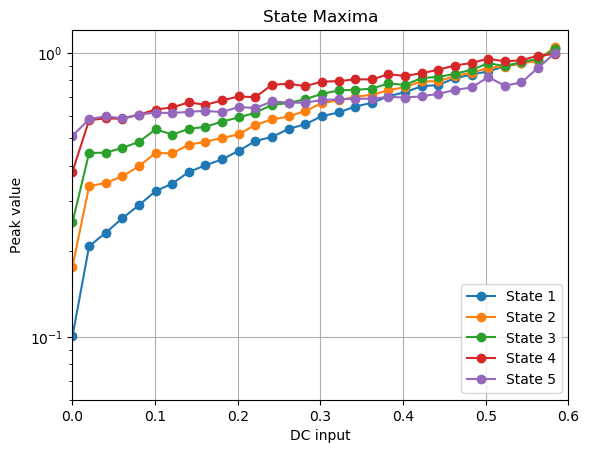

In [16]:
for i in range(order):
    semilogy(u, maxima[i, :], 'o-', label=('State %d' % (i+1)))
    if not i:
        hold(True)
grid(True)
title('State Maxima'); ylabel('Peak value'); xlabel('DC input')
xlim([0, 0.6]); ylim([6e-2, 1.2]);
legend(loc=4);

### System version information

In [ ]:
#%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%reload_ext version_information

%version_information numpy, scipy, matplotlib, deltasigma